![Adversarial example](adversarial_example.png "Adversarial example")

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn

In [3]:
from utils import MnistData
from models import ModelManager, ModelType

In [4]:
model_loaded = ModelManager.get_trained(ModelType.MnistCnnMilano)
data = MnistData(True)

In [5]:
step_size = 50 / 255

In [18]:
benign_images, labels = data.get_training_batch(1000)

In [19]:
benign_images.requires_grad = True
if benign_images.grad is not None:
    benign_images.grad.zero_()
loss = nn.CrossEntropyLoss()(model_loaded(benign_images), labels)
loss.backward()
grad = benign_images.grad

In [20]:
altered_training_images = benign_images + step_size * grad.apply_(lambda x: 1 if x >= 0 else -1)

In [21]:
altered_training_images = altered_training_images.detach()
altered_training_images.apply_(lambda x: 1 if x> 1 else (0 if x < 0 else x))  # clip

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1961, 0.1961],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1961, 0.1961],
          [0.0000, 0.0000, 0.0000,  ..., 0.1961, 0.0000, 0.1961],
          ...,
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.0000, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.0000, 0.1961, 0.1961]]],


        [[[0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          ...,
          [0.1961, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1961],
          [0.1961, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1961],
          [0.1961, 0.1961, 0.0000,  ..., 0.0000, 0.0000, 0.1961]]],


        [[[0.1961, 0.1961, 0.1961,  ..., 0.0000, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..., 0.1961, 0.1961, 0.1961],
          [0.1961, 0.1961, 0.1961,  ..

In [12]:
def get_prediction(model, image):
    my_image = image.unsqueeze(0)
    pred = model(my_image)
    maxout = max(pred[0])
    for j in range(10):
        if pred[0, j] == maxout:
            return j, maxout

In [22]:
possible_adversarials = []
for i in range(len(benign_images)):
    prediction, confidence = get_prediction(model_loaded, altered_training_images[i])
    original_prediction, original_confidence = get_prediction(model_loaded, benign_images[i])
    if prediction != labels[i] and original_prediction == data.training_labels[i]:
        params = {"Label": labels[i], "Prediction": prediction, "Confidence": confidence,
                  "Index": i, "OriginalPrediction": original_prediction, "OriginalConfidence": original_confidence}
        possible_adversarials.append(params)

In [23]:
len(possible_adversarials)

39

In [15]:
from matplotlib import pyplot as plt
import numpy as np

In [16]:
def display(image):
    first_image = image[0].reshape((28 * 28,)).detach()
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap="gray")
    plt.show()

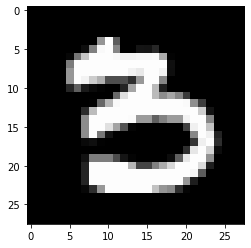

+++++


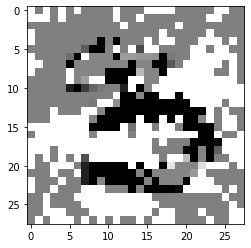

=====


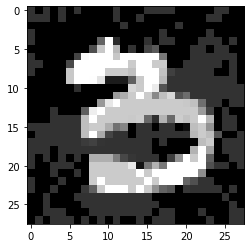

Label: 3, Prediction: 2, Confidence: 0.9999996423721313
Original prediction: 3, Original confidence: 1.0


In [24]:
adversarial = possible_adversarials[0]
original_image = benign_images[adversarial["Index"]]
altered_image = altered_training_images[adversarial["Index"]]
mask = altered_image - original_image
# mask = mask * 255
# original_image = original_image * 255
# altered_image = altered_image * 255
display(original_image)
print("+++++")
display(mask)
print("=====")
display(altered_image)
print(f"Label: {adversarial['Label']}, Prediction: {adversarial['Prediction']}, Confidence: {adversarial['Confidence']}")
print(f"Original prediction: {adversarial['OriginalPrediction']}, Original confidence: {adversarial['OriginalConfidence']}")